In [139]:
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD, UCC
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, SLSQP
from qiskit.primitives import Estimator
from qiskit.circuit.library import EvolvedOperatorAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit
from typing import List
import matplotlib as plt

import numpy as np
from copy import deepcopy
from qiskit_nature import settings
settings.use_pauli_sum_op = False

In [140]:
class BaseFermonicAdaptVQE():
    def __init__(self, ES_problem: ElectronicStructureProblem, threshold: float = 0.0016,
                 max_iter: int = 40) -> None:  # 自定义优化器等其他信息可以在这里添加

        self.mapper = JordanWignerMapper()
        self.es_problem = ES_problem
        self.estimator = Estimator()
        self.threshold = threshold
        self.max_iteration = max_iter
        # 将电子问题的哈密顿量从二次量子化形式转化为泡利算符形式(mapper就是转换到泡利算符的)
        self.hamiltonian = self.mapper.map(
            ES_problem.hamiltonian.second_q_op())
        # 设置初始态HF
        self.init_state_hf = HartreeFock(num_particles=self.es_problem.num_particles,
                                         num_spatial_orbitals=self.es_problem.num_spatial_orbitals,
                                         qubit_mapper=self.mapper)
        # 设置初始电路信息
        self.n_qubit = self.init_state_hf.num_qubits
        self.adapt_ansatz = QuantumCircuit(self.n_qubit)
        self.update_ansatz = QuantumCircuit(self.n_qubit)

        # 存放动态增长的ansatz circuit的instruction
        self.adapt_ansatz.append(self.init_state_hf, range(
            self.n_qubit))
        self.converageflag = False  # 是否收敛的标志

        # 目前已经挑选的index列表
        self._already_pick_index = []
        self.finnal_pool_op = []
        self.parameter_value = []
        # 用于存放每一步的能量
        self.solver = VQE(estimator=Estimator(),
                          ansatz=self.init_state_hf,
                          optimizer=SLSQP())
        self.pool_init()
        self.first_step()

    # 初始化池子
    def pool_init(self):
        # self.uccsd = UCC(num_particles=self.es_problem.num_particles,
        #  num_spatial_orbitals=self.es_problem.num_spatial_orbitals,
        #  excitations='sd', qubit_mapper=JordanWignerMapper(), initial_state=self.init_state_hf)

        # excitations=[1,2] 表示单激发和双激发 'sd'同理表示单激发和双激发
        # uccsd = UCC(num_particles=self.es_problem.num_particles,
        #             num_spatial_orbitals=self.es_problem.num_spatial_orbitals,
        #             excitations=[1,2],qubit_mapper=JordanWignerMapper(),initial_state=self.init_state_hf)

        # 与UCC相比,相当于自己设定了激发算符
        self.uccsd = UCCSD(num_particles=self.es_problem.num_particles, num_spatial_orbitals=self.es_problem.num_spatial_orbitals,
                           initial_state=self.init_state_hf, qubit_mapper=JordanWignerMapper())

        # 使用 uccsd.excitation_ops() 获取UCCSD变分形式中定义的所有激发算符。
        # 在UCCSD中，这些激发算符通常包括单激发和双激发，它们用于描述电子从一个轨道激发到另一个轨道的过程。
        # 构建一个费米子的激发池,这里的激发池是一个list,每一个元素都是一个激发算符,已经转换成SparsePauliOp的形式(map之后的形式)
        # 如果想切换其他算符池,需要把finnal_pool_op里的元素先拆分,分解成list进行操作,最后再合并成SparsePauliOp的形式,进行后续操作
        self.finnal_pool_op = [self.mapper.map(
            i) for i in self.uccsd.excitation_ops()]
        print(f'fermonicpool 创建完毕,size={len(self.finnal_pool_op)}个')

        # 计算每一个激发算符的对易子
        self.commutors = [1j * (self.hamiltonian @ exc - exc @
                                self.hamiltonian) for exc in self.finnal_pool_op]

    # @staticmethod
    # def my_callback(self,fun,x0,jac=None,bound=None):
    #     #     fun (callable): the function to minimize
    #     #     x0 (np.ndarray): the initial point for the optimization
    #     #     jac (callable, optional): the gradient of the objective function
    #     #     bounds (list, optional): a list of tuples specifying the parameter bounds
    #     bound=[(-2*np.pi, 2*np.pi)] * ansatz.num_parameters

    @staticmethod
    # 参数是 每一轮求得的梯度的最大值
    # 判断是否达到收敛条件
    def check_gradient_converge(value: List, criterion: float = 0.0016) -> bool:
        converge = value.max()
        if converge > criterion:
            print(f'没有达到收敛标准,标准为{criterion},当前值为{converge}')
            return False
        else:
            print(f'达到收敛标准,标准为{criterion},当前值为{converge}')
            return True

    def first_step(self):
        print('第一步,挑选第一个激发算符')
        qubit_number = self.n_qubit
        # 存放第一轮的每一个电路
        self.circuits_first = []
        # 制备n个电路,每一个电路都是一个激发算符的对易子作用在初始态上
        for i in range(len(self.finnal_pool_op)):
            qc = QuantumCircuit(qubit_number)
            qc.append(self.init_state_hf, range(qubit_number))
            self.circuits_first.append(qc)

        # 计算每一个对易子的期望值
        job = self.estimator.run(
            circuits=self.circuits_first, observables=self.commutors)
        result = job.result()
        value = np.abs(result.values)
        k = np.argmax(value)
        print(f'初始化结果:第{np.argmax(value)}项被选定,此项梯度最大,为{value[k]}')
        self._already_pick_index.append(k)
        self.iteration_index = int(1)
        # 设置这次选择出来的激发算符,演化成Ansatz
        self.next_operator = EvolvedOperatorAnsatz(
            operators=self.finnal_pool_op[k], parameter_prefix='{:02d}'.format(0), name="Fermonic"+'_'+str(k))
        # 将第一轮挑选出来的激发算符加入到电路中,含参相当于ansatz.
        self.adapt_ansatz.append(self.next_operator, range(qubit_number))
        # 设置VQE中的ansatz
        self.solver.ansatz = self.adapt_ansatz
        # 设置初始点,可以省略
        # self.solver.initial_point = [0.0] * self.next_operator.num_parameters
        self.solver.initial_point = [0.0] * self.adapt_ansatz.num_parameters
        # VQE进行优化
        self.vqe_result = self.solver.compute_minimum_eigenvalue(
            self.hamiltonian)
        # 将优化后的参数赋值给parameter_value
        self.parameter_value = self.vqe_result.optimal_point.tolist()

    def cyclic_operator(self, bound_circuit: QuantumCircuit):
        print(f'No.{self.iteration_index}轮,正在准备挑选下一块算符...')

        job = self.estimator.run(
            circuits=[bound_circuit]*len(self.commutors), observables=self.commutors)
        result = job.result()
        value = np.abs(result.values)
        k = np.argmax(value)

        # 判断即将选择的算符是否已经陷入循环
        if self.check_gradient_converge(value=value, criterion=self.threshold):
            print(f'梯度满足或者检测到循环!')
            self.converageflag = True
            # 需要拿最后一轮的k再去算一次能量,更新ansatz
            self._already_pick_index.append(k)
            self.parameter_value.append(0.0)
            self.next_operator = EvolvedOperatorAnsatz(operators=self.finnal_pool_op[k],
                                                       parameter_prefix='{:02d}'.format(self.iteration_index), name="Fermonic"+'_'+str(k))
            # 将新一轮挑选出来的激发算符加入到电路中,更新ansatz
            self.adapt_ansatz.append(self.next_operator, range(self.n_qubit))
            # 最后进行一次优化
            self.solver.ansatz = self.adapt_ansatz
            self.solver.initial_point = self.parameter_value
            self.vqe_result = self.solver.compute_minimum_eigenvalue(
                self.hamiltonian)
            self.parameter_value = self.vqe_result.optimal_point.tolist()
            self.update_ansatz = self.adapt_ansatz.assign_parameters(
                self.parameter_value)
            print(f'最后选好的index是{self._already_pick_index}')
            print(f'已经达到收敛条件!')
            return

        elif self.iteration_index > self.max_iteration:
            print(f'已经达到最大迭代次数!')
            self.converageflag = True
            print(f'目前优化的结果为{self.vqe_result.optimal_value}')
            return

        else:
            print(f'第{self.iteration_index}轮中梯度最大项为第{k}项,已被选入算符池...')
            self._already_pick_index.append(k)
            self.parameter_value.append(0.0)
            self.next_operator = EvolvedOperatorAnsatz(operators=self.finnal_pool_op[k],
                                                       parameter_prefix='{:02d}'.format(self.iteration_index), name="Fermonic"+'_'+str(k))
            # 将新一轮挑选出来的激发算符加入到电路中,更新ansatz
            self.adapt_ansatz.append(self.next_operator, range(self.n_qubit))
            # self.adapt_ansatz.append(EvolvedOperatorAnsatz(operators=self.finnal_pool_op[k],
            #                                                parameter_prefix='{:02d}'.format(self.iteration_index), name='Fermonic_'+str(k)), range(self.n_qubit))

    def run(self):
        while (self.converageflag == False and self.iteration_index < self.max_iteration):
            self.iteration_index += 1
            print(f'------------第{self.iteration_index}轮--------------')
            print(f'已经选好的index是{self._already_pick_index}')
            self.cyclic_operator(
                self.adapt_ansatz.assign_parameters(self.parameter_value))
            # 把更新后的ansatz更新到VQE中
            self.solver.ansatz = self.adapt_ansatz
            # 设置初始点优化更快,warm_start=True 会快很多
            # 但是不设置会报错,由于保存的还是上一轮的初始点,但是参数长度已经变化了
            # print(f'赋值前的长度{len(self.solver.initial_point)}')
            self.solver.initial_point = self.parameter_value
            # print(f'赋值后的长度{len(self.solver.initial_point)}')
            # 不是热启动,从0开始优化,很慢,但是精度没变化
            # self.solver.initial_point = [0.0] * self.adapt_ansatz.num_parameters
            self.vqe_result = self.solver.compute_minimum_eigenvalue(
                self.hamiltonian)
            # 将优化后的参数赋值给parameter_value
            self.parameter_value = self.vqe_result.optimal_point.tolist()
            # 将优化后的参数赋值给update_ansatz,输出时候能看到具体的参数值
            self.update_ansatz = self.adapt_ansatz.assign_parameters(
                self.parameter_value)
            print(f'此时的参数值为{self.parameter_value}')
        self.converageflag = True
        print(f'✔Adapt VQE算法结果={self.vqe_result.optimal_value}')

In [141]:
dist = 1.5
molecule = MoleculeInfo(
    ["H", "H", "H", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, dist),
                           (0.0, 0.0, dist*2), (0.0, 0.0, dist*3)],
    # ["H", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, dist),],
    # ['Be','H','H'],[(0.0,0.0,0.0),(0.0,0.0,dist),(0.0,0.0,-dist)],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)
driver = PySCFDriver().from_molecule(molecule)
problem = driver.run()

In [142]:
f1 = BaseFermonicAdaptVQE(ES_problem=problem, max_iter=3,)

fermonicpool 创建完毕,size=26个
第一步,挑选第一个激发算符
初始化结果:第19项被选定,此项梯度最大,为0.28142327514000304


In [143]:
f1.run()

------------第2轮--------------
已经选好的index是[19]
No.2轮,正在准备挑选下一块算符...
没有达到收敛标准,标准为0.0016,当前值为0.2983993637491692
第2轮中梯度最大项为第12项,已被选入算符池...
此时的参数值为[-0.34660532486559675, -0.23032372237690601]
------------第3轮--------------
已经选好的index是[19, 12]
No.3轮,正在准备挑选下一块算符...
没有达到收敛标准,标准为0.0016,当前值为0.3165231654892475
第3轮中梯度最大项为第21项,已被选入算符池...
此时的参数值为[-0.3922795803133273, -0.24822163057610816, -0.2483126056613544]
✔Adapt VQE算法结果=-3.476003441883983


In [144]:
from qiskit_algorithms import NumPyMinimumEigensolver, MinimumEigensolver

Ham = f1.hamiltonian
# 创建NumPyMinimumEigensolver实例
exact_solver = NumPyMinimumEigensolver()

# 计算基态能量
result = exact_solver.compute_minimum_eigenvalue(Ham)

# 输出基态能量
print(f"精确的基态能量为: {result.eigenvalue.real}")

精确的基态能量为: -3.5248844903988217


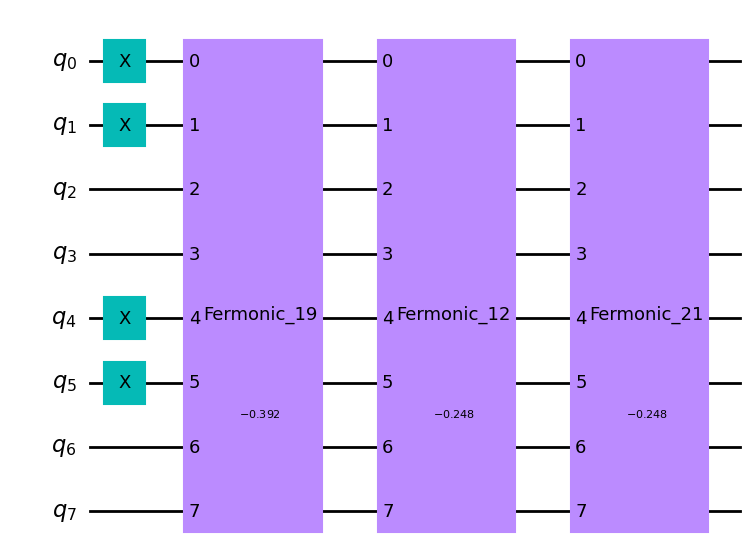

In [146]:
f1.update_ansatz.decompose().draw('mpl')